In [1]:
import sys, os
import source.map
import source.measurement
import source.random_forest
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [16]:
species = [(0.13, 130, 0, {2}, (0, 0, 1, 1), 200, 101, 100, 0.01, 0.15, 0),
           (0.2, 130, 1, {0}, (1, 0, 0, 1), 400, 151, 150, 0.01, 0.15, 3),
           (0, 10, 2, set(), (0, 0.8, 0.2, 1), 50, 40, 1000, 0.01, 0.15, 0),
          ]

the_map = source.map.Map([200, 10, 6500], 80, 80, species)

Schéma animé de monde:

<IPython.core.display.Javascript object>


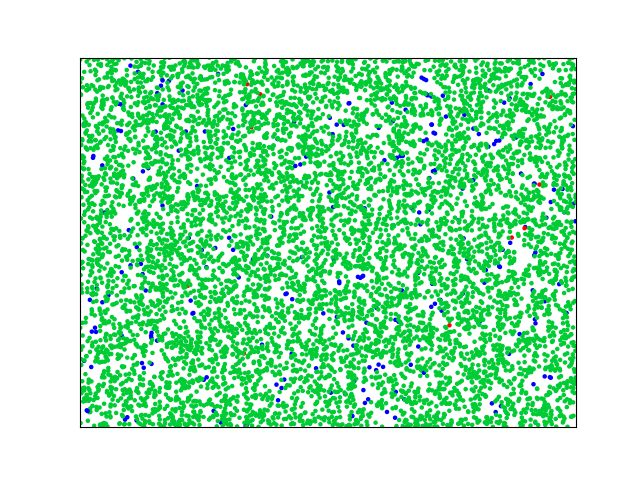

In [13]:
%matplotlib notebook

import numpy as np
import matplotlib.animation as animation

plt.close('all')


fig = plt.figure(5)
ax = plt.axes(xlim=(0, the_map.beings_map.shape[0]), ylim=(0, the_map.beings_map.shape[1]))
scat = ax.scatter([], [], s=60)
plt.xticks([]), plt.yticks([])


def init():
    scat.set_offsets([])

def update(*args):
    positions = []
    colors = []
    for i in range(len(the_map.beings_list)):
        if not the_map.beings_list[i].is_dead:
            positions.append(the_map.beings_list[i].get_position())
            colors.append(the_map.beings_list[i].color)
    scat.set_offsets(positions)
    scat.set_color(colors)
    scat.set_sizes(5 * np.ones(len(the_map.beings_list)))
    the_map.iteration()
    return scat,

anim = animation.FuncAnimation(fig, update, init_func=init, frames=range(100),
                               interval=50)
plt.show()

In [ ]:
source.measurement.draw_population(the_map,
                                   150,
                                   60,
                                   species_to_draw={0, 1, 2},
                                   stop_on_extinction=True)

In [66]:
test_result = source.measurement.survival_tests(os.path.join("data", "tests133.csv"),
                                               species,
                                               50,
                                               max_iterations=6000,
                                               test_count=100000,
                                               inital_beings_number_bounds=[(50, 400), (2, 10), (1000, 6000)],
                                               simulations_per_test=1,
                                               change_satiation_threshold=True,
                                               change_reproduction_threshold=True,
                                               change_reproduction_cooldown=True,
                                               change_inital_satiation=True,
                                               change_hunt_range=True,
                                               stop_hour=9);

In [31]:
data = pd.read_csv(os.path.join("data", "6k iterations test", "concatenated.csv"))
data[data["result"] >= 6000.0]

,Unnamed: 0,species 0 inital count,species 1 inital count,species 2 inital count,species 0 inital satiation,species 0 satiation threshold,species 0 reproduction cooldown,species 0 reproduction threshold,species 0 hunt range,species 1 inital satiation,species 1 satiation threshold,species 1 reproduction cooldown,species 1 reproduction threshold,species 1 hunt range,species 2 inital satiation,species 2 satiation threshold,species 2 reproduction cooldown,species 2 reproduction threshold,species 2 hunt range,result
4,4,101.0,6.0,4467.0,184.186850,219.641242,129.811751,138.935810,0.0,158.073655,818.449835,235.876951,114.368233,6.0,12.694418,25.030099,37.917850,965.212489,2.0,6000.0
29,29,71.0,6.0,3948.0,124.042791,203.384535,55.759180,88.760704,-1.0,311.114673,741.741426,282.233135,365.607011,1.0,10.967795,97.721266,64.761951,600.778933,1.0,6000.0
50,50,230.0,2.0,2390.0,118.220578,255.676515,143.370110,120.739738,1.0,127.388981,661.589723,349.302471,179.107410,2.0,21.990216,31.553753,47.799855,2405.677891,2.0,6000.0
87,87,140.0,5.0,1438.0,249.480937,454.168500,140.751437,108.964000,-1.0,214.688195,545.316365,253.583964,159.519350,6.0,22.302852,82.525625,63.535124,766.910113,3.0,6000.0
116,21,161.0,2.0,1237.0,105.019540,348.374108,166.049383,237.912080,-2.0,205.205747,237.677348,285.012137,129.357502,6.0,19.205072,45.601943,51.886260,1849.765233,0.0,6000.0
128,33,81.0,7.0,4234.0,157.851701,297.272863,220.068006,243.558417,-2.0,317.853964,859.703969,356.600379,179.915293,5.0,16.365880,43.346509,57.711137,842.925883,2.0,6000.0
138,43,74.0,8.0,5059.0,95.603943,131.231533,59.682781,116.530040,-1.0,186.591023,728.866521,233.330166,171.133101,6.0,12.711561,69.854435,57.352759,2234.195887,-1.0,6000.0
146,51,107.0,7.0,5549.0,133.391116,216.721883,83.573523,207.267936,-1.0,275.604739,391.198753,370.773999,291.632651,1.0,5.021157,25.798507,80.615967,2100.600981,-2.0,6000.0
162,67,213.0,10.0,1711.0,159.025128,410.641008,89.911902,234.478701,1.0,227.444323,955.621898,99.613665,202.798079,1.0,24.577253,76.981774,40.798407,1865.544838,3.0,6000.0
248,153,148.0,6.0,1123.0,314.060377,456.427814,72.097910,206.199179,1.0,185.543129,379.709407,287.390485,183.207218,1.0,19.253014,54.347580,39.873462,2108.191841,-2.0,6000.0


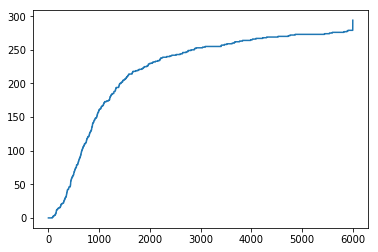

In [69]:
plt.plot([data["result"].values[data["result"].values <= x].shape[0] for x in range(0, 6001, 1)])
plt.show()

In [45]:
def concatenate_tests(dir_path):
    files = os.listdir(dir_path)
    data_frame = pd.read_csv(os.path.join(dir_path, files[0]))
    for file_name in files[1:]:
        data_frame = pd.concat((data_frame, pd.read_csv(os.path.join(dir_path, file_name))))
    data_frame.to_csv(os.path.join(dir_path, "concatenated.csv"))

concatenate_tests(os.path.join("data", "6k iterations test"))

In [5]:
data = pd.read_csv("data/6k iterations test/concatenated.csv")